# Challenge 02: Minimum Hamming Distance using a Quantum Algorithm

The Hamming distance between two binary strings (with the same number of bits) is defined as the number positions where the bits differ from each other. For example, the Hamming distance between these $6$-bit strings <span style="color:red">$0$</span>$01$<span style="color:red">$0$</span>$0$<span style="color:red">$1$</span> and <span style="color:red">$1$</span>$01$<span style="color:red">$1$</span>$0$<span style="color:red">$0$</span> is $3$.

A simple way to calculate the Hamming distance between two numbers is to perform a bitwise XOR between them, and count the number of ones in the resulting string:

$$ 001001 \oplus 101100 = 100101 \xrightarrow[]{\; \text{count ones} \;} 011 \text{ (3 in base-2)} $$

The purpose of this challenge is to develop a quantum algorithm that takes as an input an arbitrary number $m$ of $n$-bit strings, and outputs the two strings with the minimum Hamming distance between them with a resonably high probability. How high? the higher the better.

For instance, for the following input of four 4-bit strings: $[0000,1001,1100,1101]$ the algorithm should return strings $[1100,1101]$ since they only differ by one bit.

**Level 1:** Start by only considering the cases in which the answer is unique. In other words, assume that all inputs only have one pair of strings that gives the minimum Hamming distance. So inputs such as $[0000,0001,0010,0111]$ don't have to be considered because there are two solutions: $[0000,0001]$ and $[0000,0010]$.

**Level 2:** Now consider the case where more than one solution can exist and make sure the algorithm returns each of the possible solutions with equal probability. So, for the example above, the probability of measuring $[0000,0001]$ or $[0000,0010]$ should be close to $50\%$ (inputs with repeated strings should also be considered).

**Hint:** Consider looking into some of the "textbook" quantum algorithms (like Deutch-Jozsa (DJ) [1], Bernstein-Vazirani (BV) [2], Grover [3], etc.) to see if this problem can be solved with variations of these. Take for instance this pre-print [4], where a modified version of DJ was used to compute Hamming distances between two strings. Now, keep in mind that in that approach, Hamming weights were calculated using probability distributions (which require multiple runs of the algorithm), and not by amplifying states, as required by this challenge.


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[4] Bravo, José Manuel. "Calculating Hamming distance with the IBM Q Experience." Preprints (2018).

In [ ]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ , QuantumRegister , ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [ ]:
import numpy as np
import os
from math import pi
import operator

# Example 

For this example the goal is to find the minimum distance between the 

 array=['0000','0001','0010','0111']

so I will use the design of the QRAM to get all the values in one overlay, to indicate the positions of each cell in the memory is supported by X gates that through the function 'position' supports the decision of how many X gates are used per cell.

In [ ]:
array=['0000','0001','0010','0111']

The function converts the cell index into a binary value to automate how many X gates are needed 

In [ ]:
def position(inputs,valor):
    lista = []
    a = bin(inputs)[2:] 
    while len(a)<valor:
        a = '0'+a
    a=a[::-1]
    #print(a)
    for i in range(len(a)):
        if a[i] == '1':
            lista.append(i)
    return lista

The function 'qram' uses the value obtained from the function 'position' to indicate the number of X gates, also, it reads the variable of each cell, when it finds the value 1 it generates a ccx gate on the qubits that are called 'distance_h' and that will serve to find the minimum distance of hamming.

In [ ]:
def qram(qc,address,distance_h,array):
    states = 2**len(array)
    lista =[]
    count = 0
    for i in array:
        lista = position(count,states)
        for k in lista:
            qc.x(address[k])
        for index,j in enumerate(i):
            if j == '1':
                qc.ccx(address[0],address[1],distance_h[index])
        for k in lista:
            qc.x(address[k])
        qc.barrier()
        
        count+=1
    
    

For the realization of this algorithm is from the Bernstein-Vazirani algorithm to find the distances between each of the inputs as an oracle as the grover algorithm to find the minimum value of the hamming distance. Therefore it is important to make the diffuser function for the grover algorithm that aims to amplify the values that meet the conditions of the oracle.

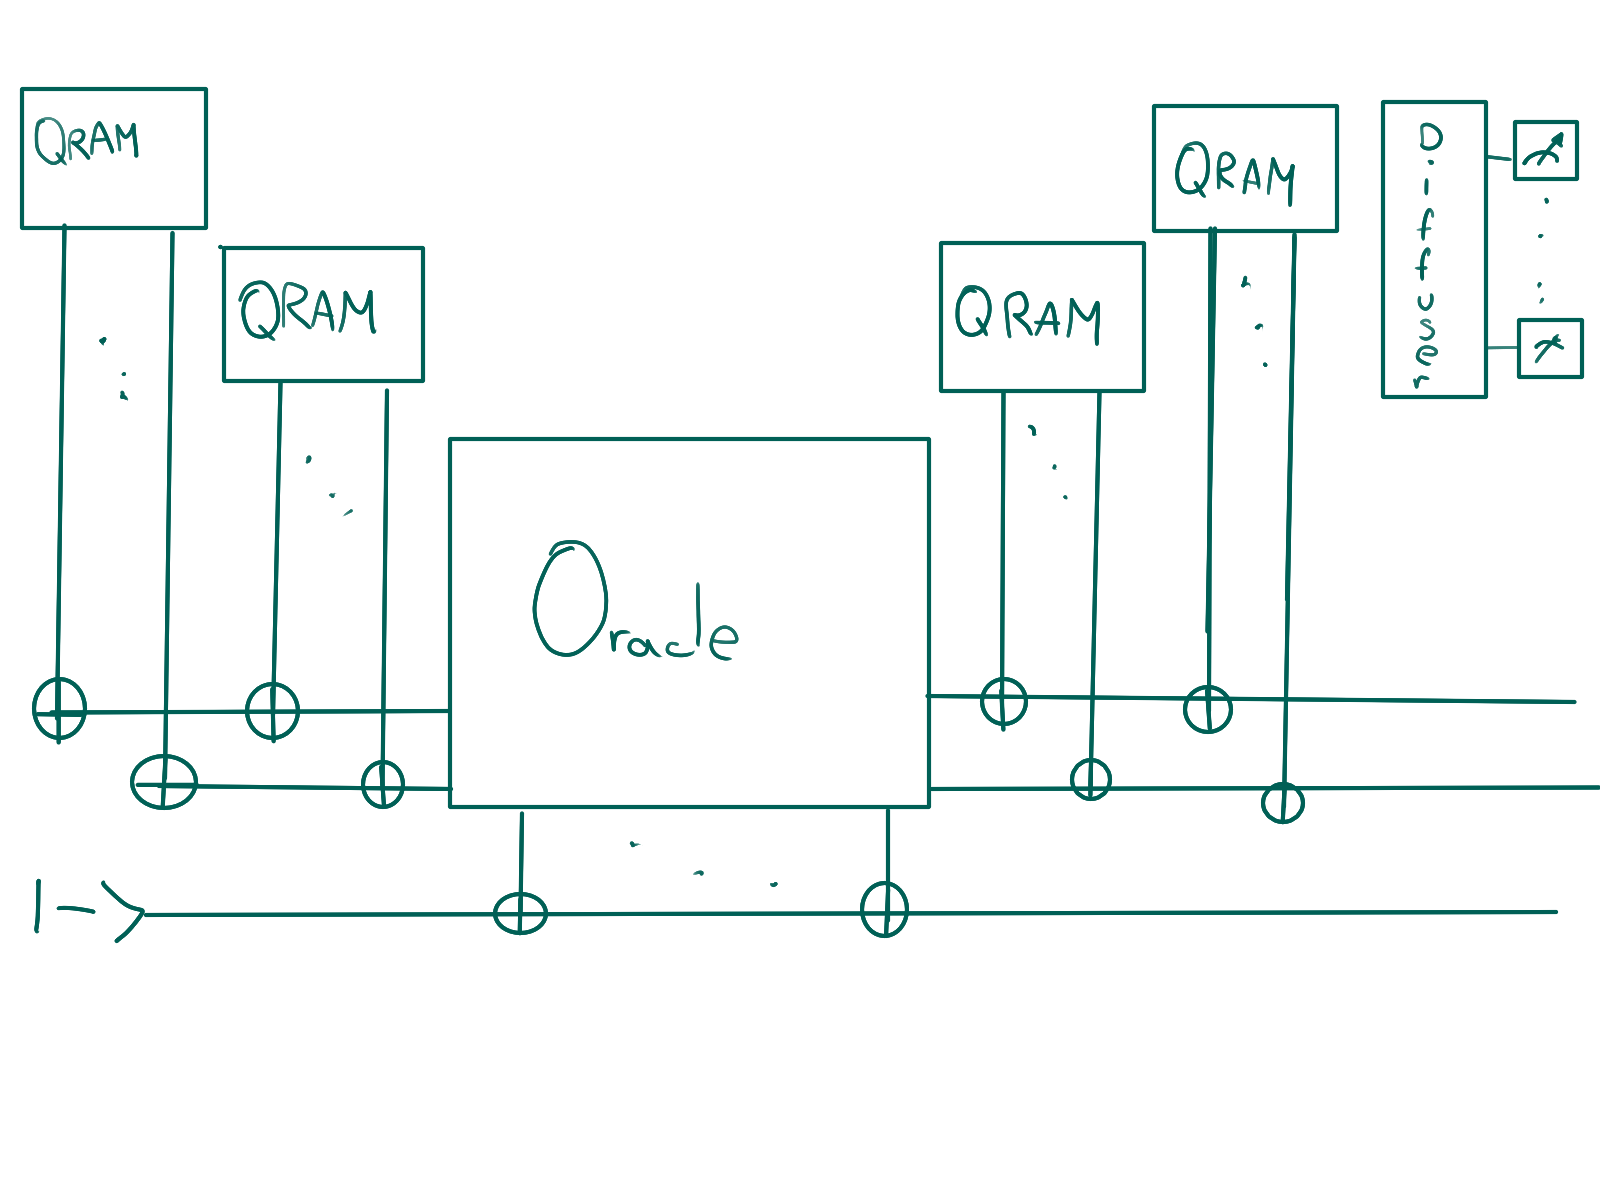

In [ ]:
from IPython.display import Image
Image('ch2.png')

In [ ]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

It generates the hamming function that develops all the process described in the previous figure and using the Bernstein-Vazirani algorithm as an oracle. 

In [ ]:
def hamming2(array):
    n=2
    address_1 = QuantumRegister(n)
    address_2 = QuantumRegister(n)
    distance_h = QuantumRegister(len(array[0]))
    reg_oracle= QuantumRegister(1)
    c_1 = ClassicalRegister(n)
    c_2 = ClassicalRegister(n)
    qc = QuantumCircuit(address_1,address_2, distance_h,reg_oracle, c_1, c_2)
   
    qc.x(reg_oracle)
    qc.h(reg_oracle)
    qc.h(address_1)
    qc.h(address_2)
    qc.barrier()
    qram(qc,address_1,distance_h,array)
    qram(qc,address_2,distance_h,array)
        
    
    qc.h(distance_h)
    qc.barrier()
    for i in distance_h:
        qc.cx(i,reg_oracle)
    qc.h(distance_h)
    qc.barrier()
    

    qc.x(distance_h[3])
    qc.mct(distance_h,reg_oracle)

    qc.x(distance_h[3])    
    qc.barrier()    

    qc.x(distance_h[0])

    qc.mct(distance_h,reg_oracle)
    qc.x(distance_h[0])
   
    qc.barrier() 
    
    qc.x(distance_h[2])
    qc.mct(distance_h,reg_oracle)
    qc.x(distance_h[2])
    qc.barrier()
    
    qc.x(distance_h[1])

    qc.mct(distance_h,reg_oracle)
    qc.x(distance_h[1])
   
    qc.barrier() 
    
    qc.h(distance_h)
    qc.barrier()
    for i in distance_h:
        qc.cx(i,reg_oracle)
    qc.h(distance_h)
    qc.barrier()
    
    qram(qc,address_2,distance_h,array)
    qram(qc,address_1,distance_h,array)
    qc.barrier() 
    qc.append(diffuser(2*n),[address_1[0],address_1[1],address_2[0],address_2[1]])
    qc.barrier() 
    qc.x(address_1)
    qc.x(address_2)
    qc.measure([address_1[0], address_1[1],address_2[0], address_2[1]], [c_1[0], c_1[1],c_2[0], c_2[1]])
    qc=qc.reverse_bits()
    return qc

Quantum circuit resulting

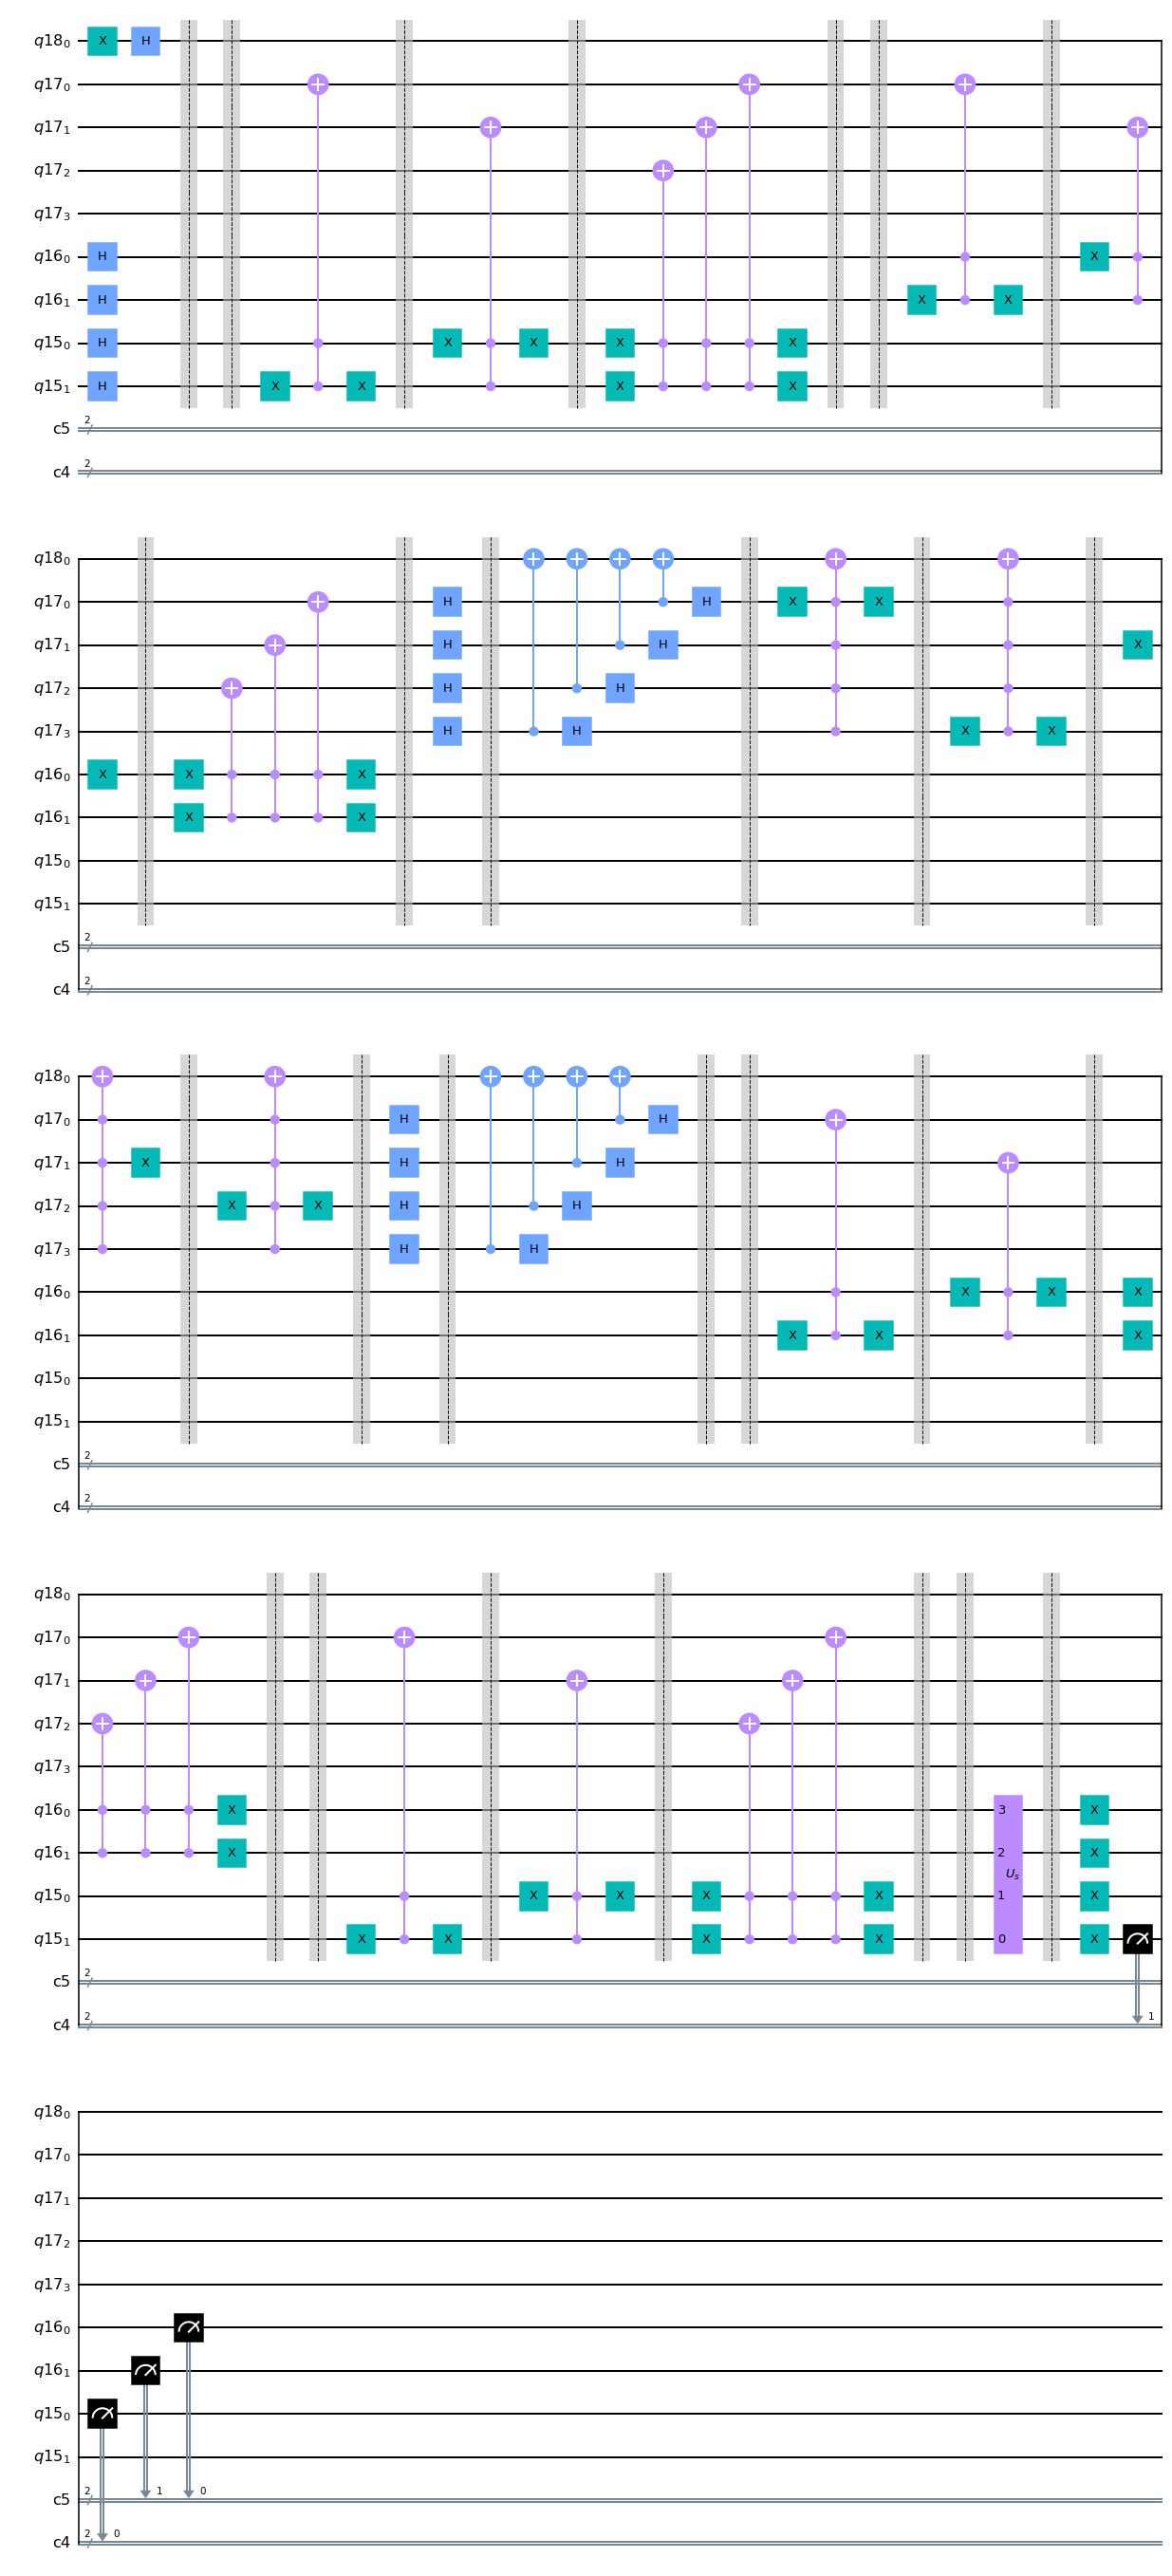

In [ ]:
array2=['0000','0001','0010','0111']
qc = hamming2(array2)
qc.draw(output='mpl')

The result for level 2 will be given 2 correct solutions, but these have 2 results because the order changes although the answer remains the same, for example [0000,0001] is equal to [0001,0000]. Also, we modified the oracle where we acquire the distances that are equal to 1 as an answer, because it is the minimum distance that can be given, in case it is 0 it means that they are the same so that does not interest.



Input ['0000','0001','0010','0111']

Expected answers [0000,0001]=[0001,0000] or [0000,0010] = [0010,0000]  

The simulation is obtained with all the values that give a distance between the different combinations of two QRAMs that have the same values highlighting the values that have a distance.

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)

{'00 01': 20590, '00 10': 20361, '01 00': 20491, '10 00': 20478}
00 01


gives as results the expected values and with the same probability if we consider that each two values represent the same, that is, we have 50% of each of the expected responses.

In [ ]:
outputs =  dict(sorted(counts.items(), key=lambda item: item[1]))

outputs

{'00 10': 20361, '10 00': 20478, '01 00': 20491, '00 01': 20590}

Consider:

00 01 is equal to [0000,0001]

00 10 is equal to [0000,0010]

01 00 is equal to [0001,0000]

10 00 is equal to [0010,0000]

in this case 00 01 and 01 00 represent the same output as 00 10 and 10 00. Therefore, we have a 50% probability of obtaining [0000,0001] and another 50% for [0000,0010], meeting the level 2 objective

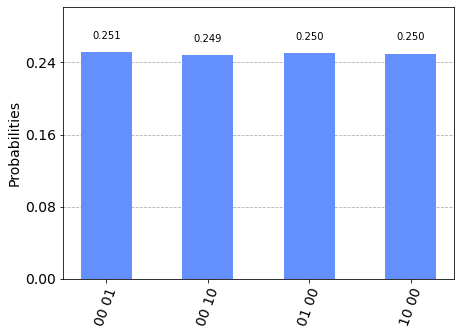

In [ ]:
plot_histogram(job.result().get_counts(qc))

In [ ]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array2[j])

0010
0000


## Other example

To check the level 2 proposal, you have the following entry

 ['0000','1001','1100','1101']

Expected answers [1001,1101]=[1101,1001] or [1100,1101] =[1101,1100]  

In [ ]:
array=['0000','1001','1100','1101']
qc = hamming2(array)
qc.draw(output='mpl')
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)
outputs =  dict(sorted(counts.items(), key=lambda item: item[1]))
print(outputs)

{'01 11': 20297, '10 11': 20552, '11 01': 20722, '11 10': 20349}
11 01
{'01 11': 20297, '11 10': 20349, '10 11': 20552, '11 01': 20722}


Consider:

01 11 is equal to [1001,1101]

10 11 is equal to [1100,1101]

11 01 is equal to [1101,1001]

11 10 is equal to [1101,1100]

in this case 01 11 and 11 01 represent the same output as 10 11 and 11 01. Therefore, we have a 50% probability of obtaining [1001,1101] and another 50% for [1100,1101].

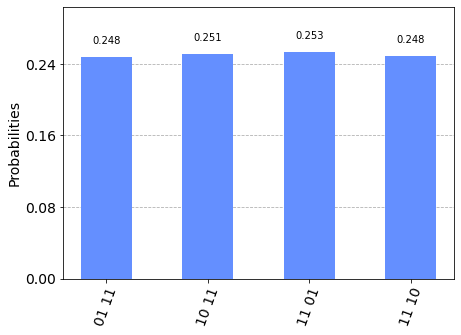

In [ ]:
plot_histogram(job.result().get_counts(qc))

In [ ]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array[j])

1101
1001


The algorithm is validated with the level 2 condition.